<p>
<img src="http://www.cerm.unifi.it/chianti/images/logo%20unifi_positivo.jpg" 
        alt="UniFI logo" style="float: left; width: 20%; height: 20%;">
<div align="right">
Massimo Nocentini<br>
<small>
<br>December 3 and 4, 2018: types definitions, gfs
</small>
</div>
</p>
<br>
<div align="center">
<b>Abstract</b><br>
In this document we collect a naive <i>type system</i> based on sets.
</div>

In [1]:
from functools import lru_cache, reduce
import operator

from sympy import *

In [2]:
%run src/commons.py

---

In [3]:
init_printing()

In [77]:
x,y,t,z = symbols('x y t z')
alpha, beta, gamma, eta = symbols(r'\alpha \beta \gamma \eta')
w = IndexedBase('w')

In [6]:
class ty:
    
    def __init__(self, *types):
        self.types = types # the list of types that I depend on.
    
    def tyvars(self):
        vs = map(operator.methodcaller('tyvars'), self.types)
        return reduce(operator.or_, vs, set())
    
    def label(self):
        raise NotImplemented # I'm an abstract type, nameless indeed.
    
    def gf_lhs(self):
        L = Function(self.label())
        return L(*self.tyvars())
    
    def gf(self):
        return define(self.gf_lhs(), self.gf_rhs())
        
    def gf_rhs(self):
        return self.definition().gf_rhs()
    
    def definition(self):
        raise NotImplemented
    
    def __or__(self, other):
        return du(self, other)
    
    def __mul__(self, other):
        return cp(self, other)

In [7]:
class cp(ty):
        
    def gf_rhs(self):
        R = map(lambda t: t.gf().rhs, self.types)
        return reduce(operator.mul, R, 1)
        
    def label(self):
        return r'\times'

In [8]:
class du(ty):
    
    def label(self):
        return r'\cup'
            
    def gf_rhs(self):
        R = map(lambda t: t.gf().rhs, self.types)
        return reduce(operator.add, R, 0)

In [144]:
class var(ty):
    
    def __init__(self, sym):
        self.sym = sym

    def label(self):
        return self.sym.name
        
    def gf_lhs(self):
        return self.sym
        
    def gf_rhs(self):
        return self.sym
    
    def tyvars(self):
        args = self.sym.args
        return set(filter(lambda a: a.is_symbol, args)) if args else set([self.sym])
    
class unit(var):
    
    def __init__(self):
        super().__init__(S(1))
        
    def label(self):
        return 'unit'
        
    def tyvars(self):
        return set()

In [10]:
(var(x) * var(y) * var(z)).gf()

In [11]:
(var(x) | var(y) | var(z)).gf()

In [45]:
boolean = var(x) | var(y)

In [46]:
boolean.gf()

In [47]:
class maybe(ty):
    
    def definition(self):
        alpha, = self.types
        return unit() | alpha
    
    def label(self):
        return r'\mathcal{M}'

In [48]:
maybe(var(alpha)).gf()

In [49]:
class rec(ty):
    
    def me(self):
        return var(self.gf_lhs())
    
    def gf(self, constraints={}):
        eq = super().gf()
        lhs = self.gf_lhs()
        sols = solve(eq, lhs)
        #print(sols)
        for sol in sols:
            for k,v in constraints.items():
                with lift_to_Lambda(eq) as feq:
                    #print(feq(*k).simplify())
                    if feq(*k).simplify() != v:
                        break
            else:  
                return Eq(lhs, sol)
        raise ValueError(sols)

In [50]:
class lst(rec):
         
    def definition(self):
        alpha, = self.types
        return unit() | (alpha * self.me())
    
    def label(self):
        return r'\mathcal{L}'

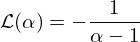

In [51]:
lst_of_alpha_tyeq = lst(var(alpha)).gf()
lst_of_alpha_tyeq

In [52]:
lst_of_alpha_tyeq.rhs.series(alpha, n=10)

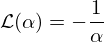

In [24]:
lst_of_maybe_of_alpha_tyeq = lst(maybe(var(alpha))).gf(constraints={})
lst_of_maybe_of_alpha_tyeq

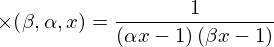

In [145]:
nats = (lst(var(alpha*x)) * lst(var(beta*x)))
nats_gf = nats.gf()
nats_gf

In [146]:
nats_gf.rhs.series(x, n=10)

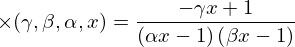

In [151]:
difference = (unit() | var(-gamma*x))
ones = nats * difference
ones.gf()

In [159]:
with lift_to_Lambda(ones.gf()) as Os:
    ones_series = Os(1,1,1,x)
ones_series.series(x, n=10)

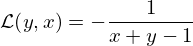

In [160]:
lst_of_boolean_tyeq = lst(boolean).gf()
lst_of_boolean_tyeq

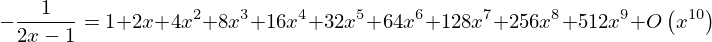

In [54]:
with lift_to_Lambda(lst_of_boolean_tyeq) as L:
    l = L(x,x)
Eq(l, l.series(x,n=10))

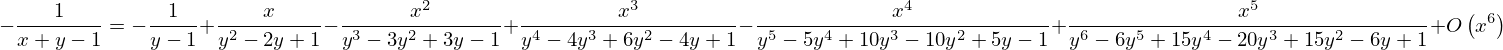

In [55]:
s = Eq(lst_of_boolean_tyeq.rhs, lst_of_boolean_tyeq.rhs.series(x), evaluate=False)
s

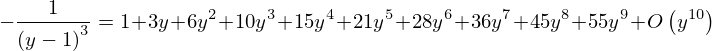

In [28]:
s2 = s.rhs.coeff(x,2).factor()
Eq(s2, s2.series(y,n=10))

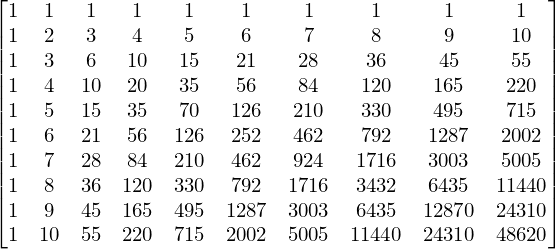

In [29]:
dim = 10

@lru_cache(maxsize=None)
def col(j):
    return lst_of_boolean_tyeq.rhs.series(x,n=dim).coeff(x,j).series(y,n=dim)

Matrix(dim, dim, lambda i,j: col(j).coeff(y,i))

In [30]:
class nnlst(rec):
         
    def definition(self):
        alpha, = self.types
        return alpha | (alpha * self.me())
    
    def label(self):
        return r'\mathcal{L}_{+}'

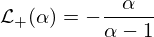

In [31]:
nnlst_of_alpha_tyeq = nnlst(var(alpha)).gf()
nnlst_of_alpha_tyeq

In [32]:
nnlst_of_alpha_tyeq.rhs.series(alpha, n=10)

In [56]:
class bin_tree(rec):
    
    def definition(self):
        alpha, = self.types
        return unit() | (alpha * self.me() * self.me())
    
    def label(self):
        return r'\mathcal{B}'

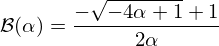

In [57]:
bin_tree_gf = bin_tree(var(alpha)).gf(constraints={(0,):1})
bin_tree_gf

In [58]:
bin_tree_gf.rhs.series(alpha, n=10)

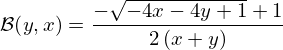

In [59]:
bin_tree_of_boolean = bin_tree(boolean).gf(constraints={(0,0):1})
bin_tree_of_boolean

In [40]:
s = bin_tree_of_boolean.rhs.series(x)

In [41]:
coeffs = [s.coeff(x,i).simplify() for i in range(6)]

In [42]:
ys = [c.series(y,n=10) for c in coeffs]
ys

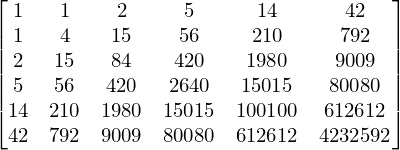

In [43]:
dim = 6

@lru_cache(maxsize=None)
def col(j):
    return s.coeff(x,j).simplify().series(y,n=dim)

Matrix(dim, dim, lambda i,j: ys[i].coeff(y,j))

In [45]:
occupancy = cp(*[unit() | var(w[i]*x) for i in range(3)]).gf()
occupancy

In [48]:
occupancy.rhs.series(x)

In [50]:
with lift_to_Lambda(occupancy) as O:
    o = O(1,1,1,x)
o.series(x)

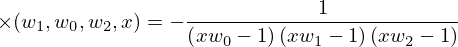

In [51]:
occupancy = cp(*[lst(var(w[i]*x)) for i in range(3)]).gf()
occupancy

In [52]:
occupancy.rhs.series(x)

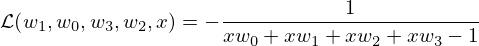

In [53]:
occupancy = lst(var(w[0]*x) | var(w[1]*x) | var(w[2]*x) | var(w[3]*x)).gf()
occupancy

In [54]:
occupancy.rhs.series(x)

In [57]:
class lst_structure_w(rec):
         
    def definition(self):
        alpha, = self.types
        me = self.me()
        return alpha | (lst(me))
    
    def label(self):
        return r'\mathcal{L}_{w}' # `_s` stands for "structure"

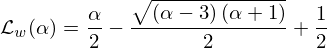

In [61]:
lst_structure_w(var(alpha)).gf(constraints={})

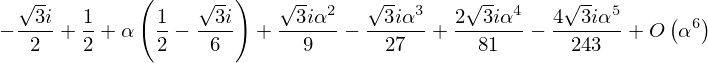

In [62]:
_.rhs.series(alpha)

In [70]:
class lst_structure(rec):
         
    def definition(self):
        alpha, = self.types
        me = self.me()
        return alpha | (lst(me) * me * me)
    
    def label(self):
        return r'\mathcal{L}_{s}' # `_s` stands for "structure"

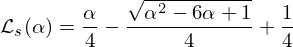

In [71]:
lst_structure(var(alpha)).gf(constraints={})

In [72]:
_.rhs.series(alpha, n=10)

In [73]:
class nnlst_structure(rec):
         
    def definition(self):
        alpha, = self.types
        me = self.me()
        return alpha * lst(nnlst(me))
    
    def label(self):
        return r'\mathcal{L}_{s}^{+}' # `_s` stands for "structure"

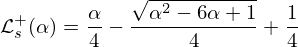

In [76]:
nnlst_structure(var(alpha)).gf(constraints={})

In [77]:
_.rhs.series(alpha, n=10)

In [78]:
class tree(rec):
         
    def definition(self):
        alpha, = self.types
        return alpha * lst(self.me())
    
    def label(self):
        return r'\mathcal{T}'

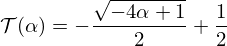

In [79]:
tree(var(alpha)).gf(constraints={(0,):0})

In [80]:
_.rhs.series(alpha, n=10)

In [81]:
class combination(rec):
         
    def definition(self):
        alpha, = self.types
        me = self.me()
        return alpha | (me * me)
    
    def label(self):
        return r'\mathcal{C}'

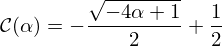

In [82]:
combination(var(alpha)).gf(constraints={})

In [83]:
_.rhs.series(alpha, n=10)

In [36]:
class ab_tree(rec):
         
    def definition(self):
        alpha, beta, = self.types
        me = self.me()
        return beta | (alpha * me * me)
    
    def label(self):
        return r'\mathcal{T}_{a,b}'

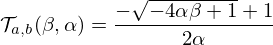

In [37]:
ab_tree_gf = ab_tree(var(alpha), var(beta)).gf(constraints={(0,0):0})
ab_tree_gf

In [38]:
fab_eq = FEq(ab_tree_gf.lhs, ab_tree_gf.rhs.series(beta, n=20).removeO(), evaluate=False)
fab_eq

In [57]:
fab_eq(x,x)

In [137]:
(_*alpha).expand()

In [40]:
#with lift_to_Lambda(fab_eq) as F:
B = fab_eq(x,1)
A = fab_eq(1,x)
A,B,

In [41]:
(A+B).expand()

In [43]:
((1+x)*A).expand()

In [60]:
class dyck(rec):
         
    def definition(self):
        alpha, beta, = self.types
        me = self.me()
        return unit() | (alpha * me * beta * me)
    
    def label(self):
        return r'\mathcal{D}'

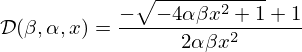

In [64]:
dyck_gf = dyck(var(alpha*x), var(beta*x)).gf(constraints={(0,0,0):1})
dyck_gf

In [66]:
dyck_gf.rhs.series(x,n=20)

In [67]:
class motzkin(rec):
         
    def definition(self):
        alpha, beta, gamma, = self.types
        me = self.me()
        return unit() | (alpha * me * beta * me) | (gamma * me)
    
    def label(self):
        return r'\mathcal{M}'

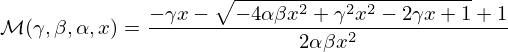

In [68]:
motzkin_gf = motzkin(var(alpha*x), var(beta*x), var(gamma*x),).gf(constraints={(0,0,0,0):1})
motzkin_gf

In [70]:
motzkin_gf.rhs.series(x,n=10)

In [76]:
with lift_to_Lambda(motzkin_gf) as M:
    motzkin_series = M(1,1,1,x)
motzkin_series.series(x,n=10)

In [83]:
class motzkin_p(rec):
         
    def definition(self):
        alpha, beta, gamma, eta = self.types
        me = self.me()
        return unit() | (alpha * me * beta * me) | (gamma * me) | (eta * me)
    
    def label(self):
        return r'\mathcal{M}^{+}'

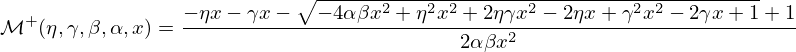

In [84]:
motzkinp_gf = motzkin_p(var(alpha*x), var(beta*x), var(gamma*x), var(eta*x),).gf(constraints={(0,0,0,0,0):1})
motzkinp_gf

In [85]:
motzkinp_gf.rhs.series(x,n=10)

In [86]:
with lift_to_Lambda(motzkinp_gf) as M:
    motzkinp_series = M(1,1,1,1,x)
motzkinp_series.series(x,n=10)

In [125]:
class fibo(rec):
         
    def definition(self):
        alpha, beta, = self.types
        me = self.me()
        return unit() | alpha | ((beta | (alpha * beta)) * me)
    
    def label(self):
        return r'\mathcal{F}'

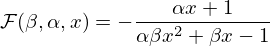

In [127]:
fibo_gf = fibo(var(alpha*x), var(beta*x),).gf(constraints={})
fibo_gf

In [128]:
fibo_gf.rhs.series(x,n=10)

In [129]:
with lift_to_Lambda(fibo_gf) as F:
    fibo_series = F(1,1,x)
fibo_series.series(x,n=10)

In [123]:
class lamda(rec):
         
    def definition(self):
        gamma, = self.types
        gamma1 = gamma | var(Dummy()*x)
        me = self.me()
        return gamma | (me * me) | (gamma * me)
    
    def label(self):
        return r'\mathcal{L}_{\Gamma}'

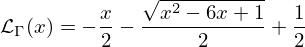

In [124]:
lamda_gf = lamda(var(x)).gf(constraints={})
lamda_gf

In [112]:
lamda_gf.rhs.series(x,n=10)

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.